# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [ ]:
predicting the price of a used car, using features given in the file. We have around 426K used cars. This problem is regression problem and I will be using panda, seaborn, sklearn as tools.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
warnings.filterwarnings('ignore')

In [4]:
#Read the file
df = pd.read_csv('vehicles.csv')
# Drop all rows with missing values to ensure clean and complete data for modeling
df = df.dropna()
# Display the number of missing (NaN) values in each column of the dataset
print(df.isnull().sum())


id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64


In [5]:
print(df.head())
print(df.info())
print(df.describe())


             id      region   price    year manufacturer              model  \
126  7305672709      auburn     0.0  2018.0    chevrolet  express cargo van   
127  7305672266      auburn     0.0  2019.0    chevrolet  express cargo van   
128  7305672252      auburn     0.0  2018.0    chevrolet  express cargo van   
215  7316482063  birmingham  4000.0  2002.0       toyota               echo   
219  7316429417  birmingham  2500.0  1995.0          bmw               525i   

     condition    cylinders fuel  odometer title_status transmission  \
126   like new  6 cylinders  gas   68472.0        clean    automatic   
127   like new  6 cylinders  gas   69125.0        clean    automatic   
128   like new  6 cylinders  gas   66555.0        clean    automatic   
215  excellent  4 cylinders  gas  155000.0        clean    automatic   
219       fair  6 cylinders  gas  110661.0        clean    automatic   

                   VIN drive       size   type paint_color state  
126  1GCWGAFP8J1309579   

In [6]:
#Describe price baseline
print(df['price'].describe().round(2))

count      7009.00
mean      15465.20
std       13367.34
min           0.00
25%        6499.00
50%       11950.00
75%       21700.00
max      150000.00
Name: price, dtype: float64


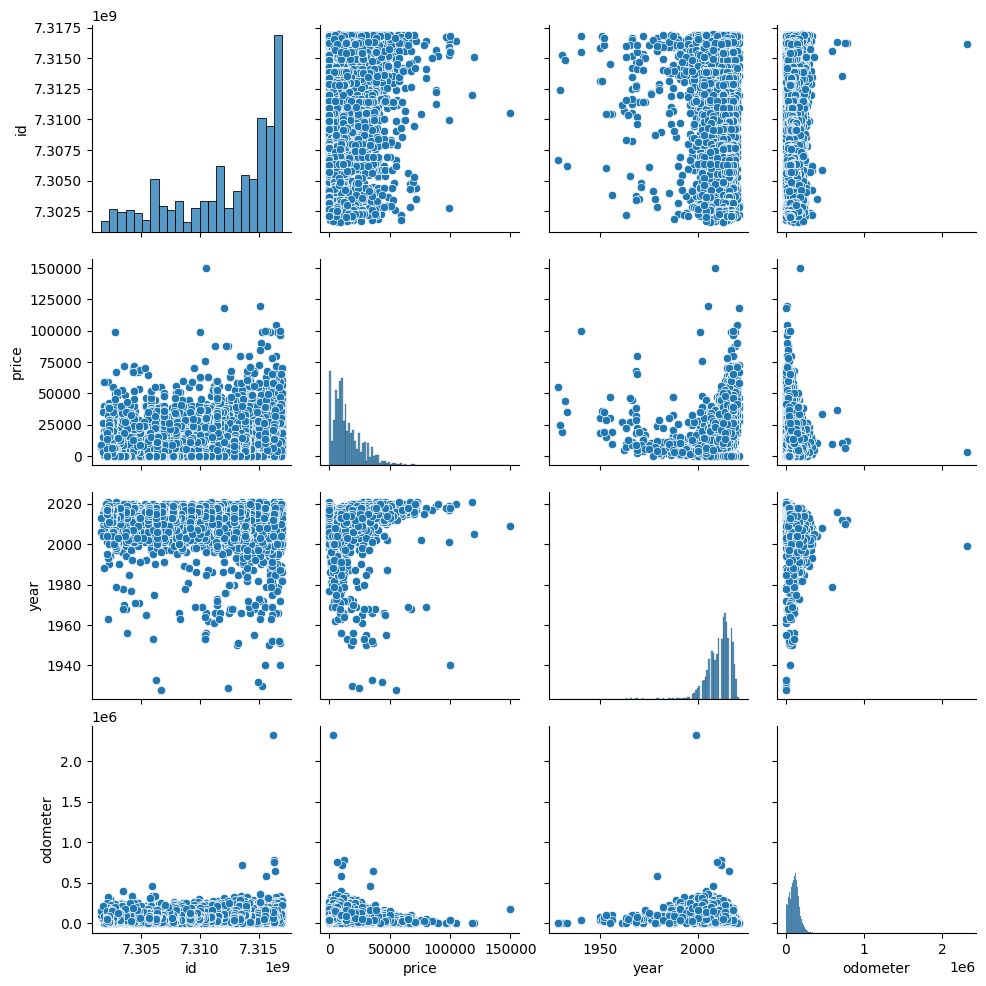

In [7]:
#Display a pairplot
sns.pairplot(df)
plt.show()


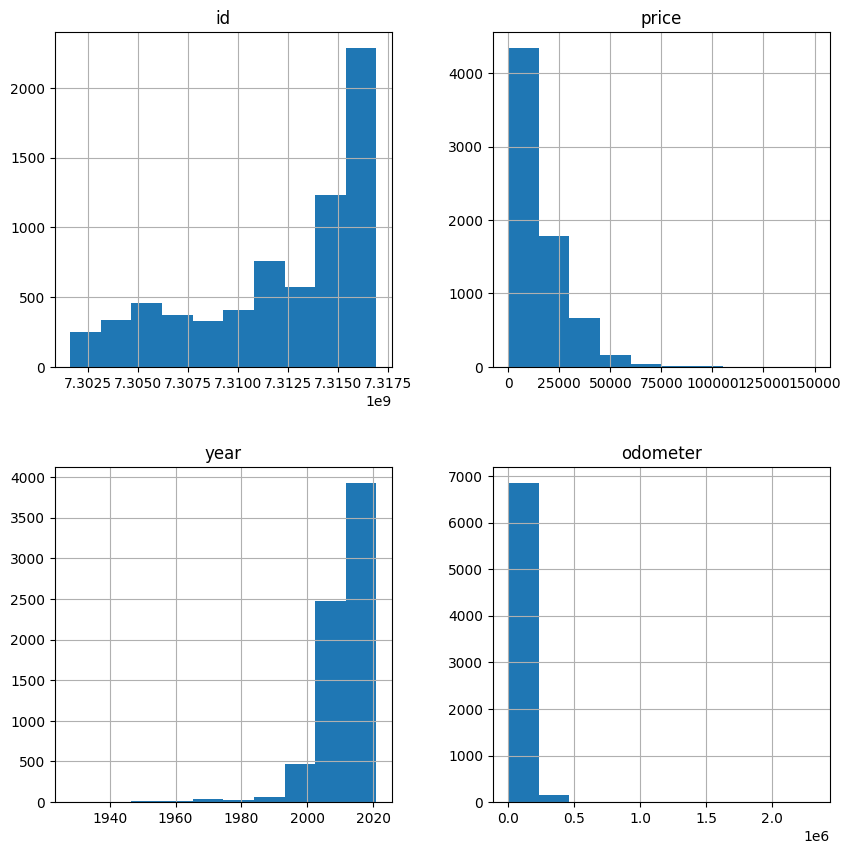

In [8]:
df.hist(figsize=(10, 10))
plt.show()

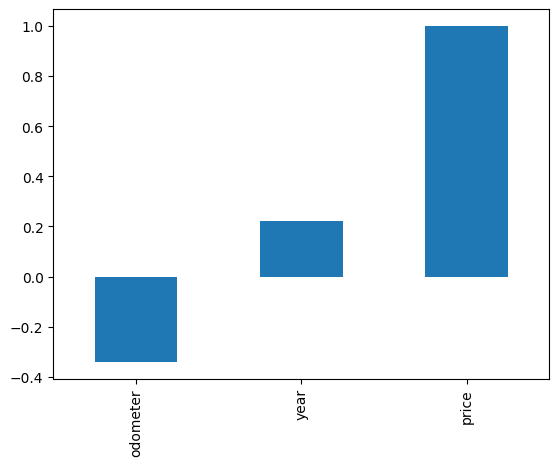

In [9]:
corr = df.corr(numeric_only=True).round(2)
corr['price'][1:].sort_values().plot(kind='bar')
plt.show()

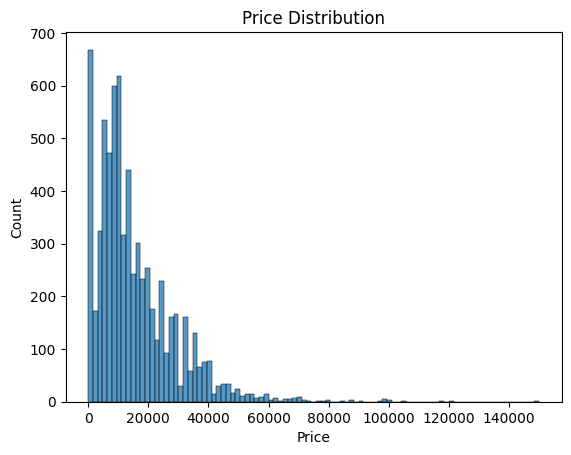

In [10]:
#Display a histogram of the prices of the car
sns.histplot(df['price'])
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

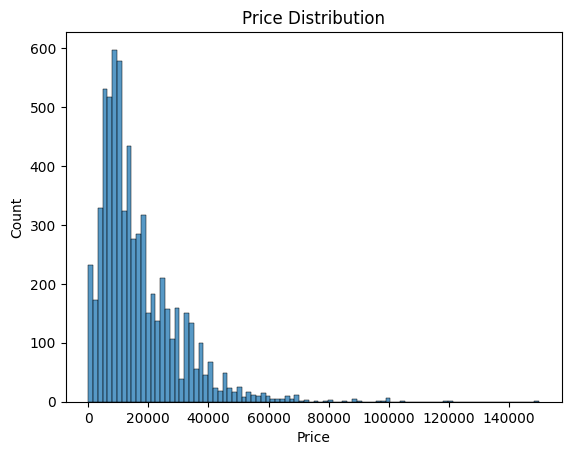

In [11]:
#Removing the cars with prices showing $0 price
df_non_zero = df[df['price'] > 0]
sns.histplot(df_non_zero['price'])
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [12]:
# Remove the target variable 'price' from the dataset, id (not relevant) and all other columns which have big dataset
X = df_non_zero.drop(['price', 'id', 'region', 'manufacturer', 'model', 'VIN', 'drive', 'paint_color', 'state'], axis = 1)
# Extract the target variable 'price' as the response vector y
y = df_non_zero['price']

In [14]:
print(X.dtypes)

year            float64
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
size             object
type             object
dtype: object


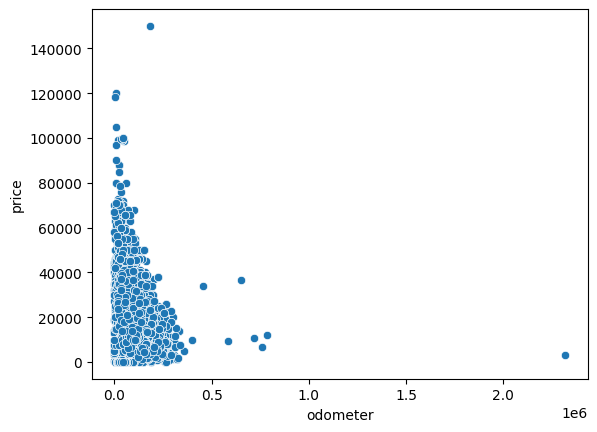

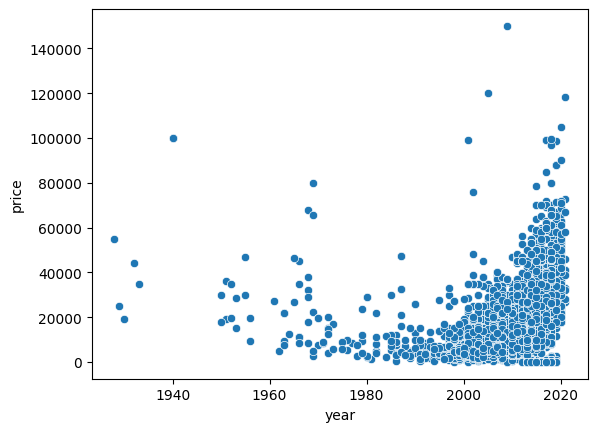

In [13]:
#Display scatter plot to show the relationship between odometer and price
sns.scatterplot(x = 'odometer', y = 'price', data = df_non_zero)
plt.show()

#Display scatter plot to show the relationship between year and price
sns.scatterplot(x = 'year', y = 'price', data = df_non_zero)
plt.show()

In [15]:
numerical_features = ['year', 'odometer']
categorical_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'size', 'type']

In [16]:
# Split the dataset into training and testing sets (80% train, 20% test) for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


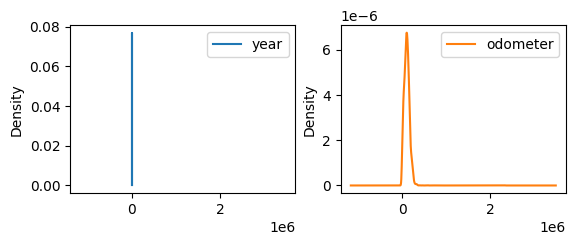

In [17]:
X_train.plot(kind = 'kde', subplots = True, layout = (2, 2));

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [20]:
# Create a pipeline that applies polynomial feature transformation (degree 1) followed by linear regression
preprocessor = ColumnTransformer(
      transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='if_binary'), categorical_features)
        ],
        remainder='passthrough'
    )

pipe = make_pipeline(
    preprocessor,
    LinearRegression(),
)

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

#Extracting feature names
feature_names = preprocessor.get_feature_names_out()

#Get the coefficient
coef = pipe.named_steps['linearregression'].coef_

#Create a DataFrame to map names and coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})
print(coef_df.head(50))

#Predict the data
pred = pipe.predict(X_test)

                        Feature   Coefficient
0                     num__year   2839.313155
1                 num__odometer  -4543.447723
2      cat__condition_excellent      1.147564
3           cat__condition_fair  -5452.109473
4           cat__condition_good  -1293.719987
5       cat__condition_like new   2100.961415
6            cat__condition_new   8800.118371
7        cat__condition_salvage  -4156.397891
8   cat__cylinders_10 cylinders  -3087.748974
9   cat__cylinders_12 cylinders  -1729.118900
10   cat__cylinders_3 cylinders  -1261.616004
11   cat__cylinders_4 cylinders  -1977.049728
12   cat__cylinders_5 cylinders  -1418.720707
13   cat__cylinders_6 cylinders   1596.601467
14   cat__cylinders_8 cylinders   4516.139355
15         cat__cylinders_other   3361.513491
16             cat__fuel_diesel   8374.770075
17           cat__fuel_electric  -3515.331794
18                cat__fuel_gas  -3493.493707
19             cat__fuel_hybrid   -258.253540
20              cat__fuel_other  -

In [21]:
#Create ridge regression pipleine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='if_binary'), categorical_features)
    ],
    remainder='passthrough'
)

pipe_ridge = make_pipeline(
    preprocessor,
    Ridge(alpha=1.0)
)

# Fit the pipeline to the training data
pipe_ridge.fit(X_train, y_train)

#Extracting feature names
feature_names = preprocessor.get_feature_names_out()

#Get the coefficient
ridge_coef = pipe_ridge.named_steps['ridge'].coef_

#Create a DataFrame to map names and coefficients
coef_ridge_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_coef
})
print(coef_ridge_df.head(50))

#Predict the data
pred_ridge = pipe_ridge.predict(X_test)


                        Feature  Coefficient
0                     num__year  2828.317679
1                 num__odometer -4546.030095
2      cat__condition_excellent   -46.314444
3           cat__condition_fair -5388.101447
4           cat__condition_good -1337.988803
5       cat__condition_like new  2057.955247
6            cat__condition_new  8402.300551
7        cat__condition_salvage -3687.851104
8   cat__cylinders_10 cylinders -3032.448376
9   cat__cylinders_12 cylinders -1258.408027
10   cat__cylinders_3 cylinders -1102.295712
11   cat__cylinders_4 cylinders -1902.163294
12   cat__cylinders_5 cylinders -1314.137578
13   cat__cylinders_6 cylinders  1658.917793
14   cat__cylinders_8 cylinders  4580.250780
15         cat__cylinders_other  2370.284413
16             cat__fuel_diesel  8159.059593
17           cat__fuel_electric -2780.227228
18                cat__fuel_gas -3687.291446
19             cat__fuel_hybrid  -447.103876
20              cat__fuel_other -1244.437044
21      ca

In [22]:
#Create Lasso regression pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='if_binary'), categorical_features)
    ],
    remainder='passthrough'
)

pipe_lasso = make_pipeline(
    preprocessor,
    Lasso(alpha = 1.0)
)

# Fit the pipeline to the training data
pipe_lasso.fit(X_train, y_train)

#Extracting feature names
feature_names = preprocessor.get_feature_names_out()

#Get the coefficient
lasso_coef = pipe_lasso.named_steps['lasso'].coef_

#Create a DataFrame to map names and coefficients
coef_lasso_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coef
})
print(coef_lasso_df.head(50))

#Predict the data
pred_lasso = pipe_lasso.predict(X_test)




                        Feature   Coefficient
0                     num__year   2830.946857
1                 num__odometer  -4546.893656
2      cat__condition_excellent      0.513714
3           cat__condition_fair  -5355.913360
4           cat__condition_good  -1289.310956
5       cat__condition_like new   2099.540847
6            cat__condition_new   8561.801123
7        cat__condition_salvage  -3374.096418
8   cat__cylinders_10 cylinders  -1736.806940
9   cat__cylinders_12 cylinders     -0.000000
10   cat__cylinders_3 cylinders      0.000000
11   cat__cylinders_4 cylinders   -650.668139
12   cat__cylinders_5 cylinders     -0.000000
13   cat__cylinders_6 cylinders   2912.661183
14   cat__cylinders_8 cylinders   5838.123576
15         cat__cylinders_other   2443.613150
16             cat__fuel_diesel   9568.219777
17           cat__fuel_electric   -250.711618
18                cat__fuel_gas  -2290.568388
19             cat__fuel_hybrid    885.971789
20              cat__fuel_other   

In [30]:

# Correct parameter grid
parameters = {
    'lasso__alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 0, 0.001, 0.005, 1, 5, 10, 100]
}

# Create the GridSearch CV object
lasso_regressor = GridSearchCV(
    pipe_lasso,
    parameters,
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit to training data
lasso_regressor.fit(X_train, y_train)

# Predict on test set using the best model
pred_lasso_grid = lasso_regressor.predict(X_test)


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [24]:
#Display the square root error
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(f'Linear regression RMSE: {rmse:.2f}')

print("Sample predictions:", pred[:5])
print("Actual values:", y_test[:5].values)




Linear regression RMSE: 8751.14
Sample predictions: [18496.32626529 21404.47131533 18627.52186373  9898.4864079
 25551.17029294]
Actual values: [14995. 13900.  6990.  8950. 32129.]


In [25]:
#Display the square root error
mse = mean_squared_error(y_test, pred_ridge)
rmse = np.sqrt(mse)
print(f'Ridge RMSE: {rmse:.2f}')

Ridge RMSE: 8752.34


In [26]:
#Display the square root error
rmse = np.sqrt(mean_squared_error(y_test, pred_lasso))
print(f'Lasso RMSE: {rmse:.2f}')

Lasso RMSE: 8752.13


In [31]:
#Display the square root error
rmse_lasso_gridcv = np.sqrt(mean_squared_error(y_test, pred_lasso))
print(f'Lasso RMSE with gridcv: {rmse_lasso_gridcv:.2f}')

Lasso RMSE with gridcv: 8752.13


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.